In [1]:
import os.path
import pickle

import librosa
import numpy as np
import pandas as pd
from keras.src.callbacks import ModelCheckpoint
from keras.src.utils import to_categorical
from matplotlib import pyplot as plt
from python_speech_features import mfcc
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from models.instrument_first_models import CNN_One, RNN_One
from utils.config import InstrumentConfig

from utils.instrument_data import InstrumentDataManipulator, DataPreprocessor
from scipy.io import wavfile

from sklearn.utils import compute_class_weight
from keras.models import load_model

#### Load DataFrame information and Class Distribution

0.2176875
19.2484375
300


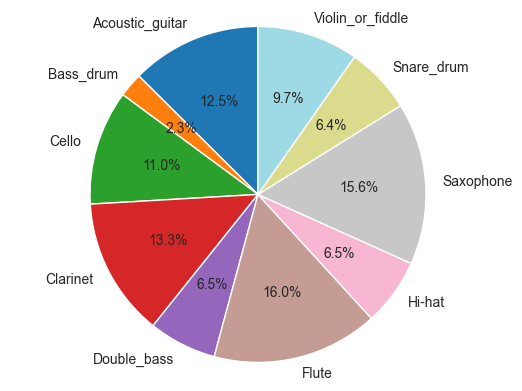

Index(['5388d14d.wav', 'c685f05f.wav', '36d20ab5.wav', 'd6665734.wav',
       '7352e28f.wav', '8fa096bf.wav', '2f9c5f62.wav', '9cd05a2b.wav',
       'ab465bf9.wav', 'c40632d7.wav',
       ...
       'e43f7db2.wav', '3c66098d.wav', 'ad42e493.wav', '740e5bb7.wav',
       '800b401e.wav', '3c713bcf.wav', '2fc00271.wav', 'b0c06255.wav',
       '71c6451f.wav', '5de123c3.wav'],
      dtype='object', name='fname', length=300)


In [2]:
df = pd.read_csv('../statistics/instruments.csv')
df.set_index('fname', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('../clean/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

min_length = min(df["length"])
max_length = max(df["length"])
print(min_length)
print(max_length)
print(len(df))

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].sum()

cmap = plt.get_cmap('tab20')
colors = cmap(np.linspace(0, 1, len(class_dist)))
fig, ax = plt.subplots()
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%', shadow=False, startangle=90, colors=colors)
ax.axis('equal')
plt.show()

n_samples = int(df['length'].sum()/0.1) # a tenth of a second

prob_dist = class_dist / class_dist.sum() # probability distribution of each instrument being picked

print(df.index)

#### Test/Train Data

In [3]:
config = InstrumentConfig(mode='recurrent')
config.model_path = "../instrument_models/kaggle_models/kaggle_rnn_one.keras"
data_manipulator = InstrumentDataManipulator(config)

X, y = data_manipulator.build_random_data(n_samples=n_samples, class_dist=class_dist, prob_dist=prob_dist, df=df, classes=classes)
print("X shape : ", X.shape)
print("y shape : ", y.shape)  # one-hot encoded class matrix

y_flat = np.argmax(y, axis=1)
input_shape = (X.shape[1], X.shape[2])
print("RNN Input Shape : ", input_shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("X_train shape : ", X_train.shape)
print("y_train shape : ", y_train.shape)  # one-hot encoded class matrix

print("X_test shape : ", X_test.shape)
print("y_test shape : ", y_test.shape)  # one-hot encoded class matrix

print(y_flat)
# make sure that network doesn't develop bias and begins to take decisions based on the percentage of a given class in the dataset
class_weight = compute_class_weight('balanced', classes=np.unique(y_flat),
                                    y=y_flat)  # helps accuracy and loss by a small margin / reduces bias in the network

print(class_weight)

class_weight_dict = {index: value for index, value in enumerate(class_weight)}

Loading existing data for recurrent model
X shape :  (26404, 9, 13)
y shape :  (26404, 10)
RNN Input Shape :  (9, 13)
X_train shape :  (21123, 9, 13)
y_train shape :  (21123, 10)
X_test shape :  (5281, 9, 13)
y_test shape :  (5281, 10)
[4 5 2 ... 7 6 2]
[0.79939449 4.21789137 0.89809524 0.7620202  1.62786683 0.60283105
 1.58107784 0.64668136 1.46852058 1.04902662]


#### Train and Save the Model

In [4]:
model_wrapper = RNN_One(input_shape=input_shape, output_shape=len(classes))
model_wrapper.create_model()

checkpoint = ModelCheckpoint(filepath=config.model_path, monitor='val_acc', verbose=1, mode="max", save_best_only=True,
                             save_weights_only=False)

history = model_wrapper.model.fit(X_train, y_train, epochs=10, batch_size=32, shuffle=True, validation_data=(X_test, y_test),
                        callbacks=[checkpoint], class_weight=class_weight_dict)

model_wrapper.model.save(config.model_path)

C:\Proiecte SSD\Licenta\Basic-Fourier-Usage\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 9, 128)         │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 9, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 9, 64)          │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 9, 32)          │         2,080 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 9, 16)          │           528 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 9, 8)           │           136 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 72)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           730 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,018 (843.82 KB)

 Trainable params: 216,018 (843.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.1692 - loss: 2.1002 - mse: 0.0860 - val_accuracy: 0.4842 - val_loss: 1.4518 - val_mse: 0.0670
Epoch 2/10
 14/661 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5016 - loss: 1.3076 - mse: 0.0647

C:\Proiecte SSD\Licenta\Basic-Fourier-Usage\venv\lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


661/661 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4979 - loss: 1.2719 - mse: 0.0644 - val_accuracy: 0.5868 - val_loss: 1.1315 - val_mse: 0.0542
Epoch 3/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5958 - loss: 1.0299 - mse: 0.0532 - val_accuracy: 0.6726 - val_loss: 0.9282 - val_mse: 0.0448
Epoch 4/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6728 - loss: 0.8599 - mse: 0.0445 - val_accuracy: 0.6895 - val_loss: 0.8501 - val_mse: 0.0412
Epoch 5/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7146 - loss: 0.7508 - mse: 0.0389 - val_accuracy: 0.7667 - val_loss: 0.6869 - val_mse: 0.0326
Epoch 6/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7486 - loss: 0.6805 - mse: 0.0351 - val_accuracy: 0.7766 - val_loss: 0.6606 - val_mse: 0.0312
Epoch 7/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7685 - loss: 0.6239 - mse: 0.0324 - val_accuracy: 0.7998 - val_loss: 0.5829 - val_mse: 0.0277
Epoch 8/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/s

#### Train Results

In [5]:
epochs = list(range(10))
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

KeyError: 'acc'

In [ ]:
import seaborn as sns
y_pred = model_wrapper.model.predict(X_test)

y_pred_f = []
for y_val in y_pred:
    l = np.argmax(y_val)
    y_pred_f.append(l)
y_pred_f = np.array(y_pred_f)
y_pred_f = to_categorical(y_pred_f, num_classes=len(classes))
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred_f)
print("Accuracy : ", accuracy)


y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()